# Homework 3
### Optimization with Stochastic Gradient Descent

In [10]:
import numpy as np
import matplotlib.pylab as plt

from math import ceil

In [11]:
def SGD(l, grad_l, w0, data, batch_size, n_epochs, alpha=0.01):
    """
        Arguments:
            l: the function l(w; D) we want to optimize. It is supposed to be a Python function, not an array.
            grad_l: the gradient of l(w; D). It is supposed to be a Python function, not an array.
            w0: an n-dimensional array which represents the initial iterate. By default, it should be randomly sampled.
            data: a tuple (x, y) that contains the two arrays x and y, where x is the input data, y is the output data.
            batch_size: an integer. The dimension of each batch. Should be a divisor of the number of data.
            n_epochs: an integer. The number of epochs you want to repeat the iterations.
        Returns:
            w: an array that contains the value of w_k FOR EACH iterate w_k (not only the latter).
            f_val: an array that contains the value of l(w_k; data) FOR EACH iterate w_k ONLY after each epoch.
            grads: an array that contains the value of grad_l(w_k; data) FOR EACH iterate w_k ONLY after each epoch.
            err: an array the contains the value of ||grad_l(w_k; data)||_2 FOR EACH iterate w_k ONLY after each epoch.
    """
    X, Y = data
    d, N = X.shape

    # number of epochs * iterations per epoch
    tot_iterations = ceil(n_epochs * ceil(N / batch_size))

    w = np.zeros(tot_iterations + 1, dtype=object)
    f_val = np.zeros(n_epochs, dtype=object)
    grads = np.zeros(n_epochs, dtype=object)
    err = np.zeros(n_epochs, dtype=object)

    w[0] = w0
    k = 0

    for epoch in range(n_epochs):
        print(f"--> Epoch {epoch}")

        # Shuffle the dataset
        rng = np.random.default_rng()
        D = np.concatenate((Y, X.T), axis=1)
        rng.shuffle(D)
        X = D[:, 1:].T
        Y = D[:, 0].reshape(-1, 1)
        
        batches_num = ceil(N / batch_size)
        for batch in range(batches_num):
            # print(f"\tBatch {batch}")
            Mx = X[:, batch*batch_size:(batch+1)*batch_size]
            My = Y[batch*batch_size:(batch+1)*batch_size]
            M = (Mx, My)
            # Gradient descent step
            k = (epoch * batches_num) + batch
            w[k+1] = w[k] - alpha * grad_l(w[k], M) 

        f_val[epoch] = l(w[k+1], data)
        grads[epoch] = grad_l(w[k+1], data)
        
        err[epoch] = np.linalg.norm(grads[epoch])
        print(err[epoch])
    
    return w, f_val, grads, err

In [12]:

# Load MINST dataset
import pandas as pd
df = pd.read_csv("../data/data.csv")
data_raw = np.array(df)
X_raw = data_raw[:, 1:]
y_raw = data_raw[:, 0]
X_raw.shape, y_raw.shape

((42000, 784), (42000,))

In [13]:
digit_list = [0, 9]

mask = [y_i in digit_list for y_i in y_raw]
y = y_raw[mask]
X = X_raw[mask, :]
X.shape, y.shape

((8320, 784), (8320,))

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
X_train = X_train.T
X_test = X_test.T
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((784, 6656), (784, 1664), (6656, 1), (1664, 1))

In [15]:
def sigmoid(x):
    return 1./(1.+np.exp(-x))

def der_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [16]:
def l(w, D):
    X, y = D
    d, N = X.shape
    return np.sum(np.power(np.linalg.norm(sigmoid(X.T @ w) - y, axis=1), 2))/N

def grad_l(w, D):
    X, y = D
    d, N = X.shape
    der = der_sigmoid(X.T @ w)
    res = der * X.T * (sigmoid(X.T @ w) - y)
    temp = (2*np.sum(res, axis=0)/N).reshape((-1,1))
    return temp

def grad_l2(w, D):
    X, y = D
    d, N = X.shape
    def grad_step(arg):
        x_i, y_i = (arg[1:], arg[:1])
        res_step = der_sigmoid(x_i.T @ w) * x_i.T * (sigmoid(x_i.T @ w) - y_i)
        return res_step
    full_D = np.concatenate((y.T, X), axis=0)
    tmp = np.apply_along_axis(grad_step, 0, full_D)
    res = np.sum(tmp, axis=1) / N
    return res.reshape((-1,1))



In [17]:
# init weights
rng = np.random.default_rng()
w0 = rng.normal(size=(X_train.shape[0] + 1, 1))
X_hat = np.concatenate((np.ones((1, X_train.shape[1])), X_train), axis=0)

In [41]:
n_epochs = 100
batch_size = 100
w, f_val, grads, err = SGD(l, grad_l2, w0, (X_hat, y_train), batch_size, n_epochs, alpha=0.005)

--> Epoch 0


/var/folders/m9/2qy1g_cd5mjcg_cqty8ydzq00000gn/T/ipykernel_8390/1431357966.py:2: RuntimeWarning: overflow encountered in exp
  return 1./(1.+np.exp(-x))


0.6716059482169536
--> Epoch 1
0.717436354518143
--> Epoch 2
1.2293018695390698
--> Epoch 3
0.0006659519686623545
--> Epoch 4
0.0009871104941986855
--> Epoch 5
0.0019401657964956257
--> Epoch 6
0.008685510794458073
--> Epoch 7
0.4193263379998598
--> Epoch 8
0.9643805968845511
--> Epoch 9
0.03236956745532475
--> Epoch 10
0.003926360725691207
--> Epoch 11
0.004449479642892246
--> Epoch 12
0.07391600961568243
--> Epoch 13
0.5871546845679799
--> Epoch 14
5.64748949848178e-06
--> Epoch 15
5.6269082506932596e-06
--> Epoch 16
5.60647663535975e-06
--> Epoch 17
5.586193048016402e-06
--> Epoch 18
5.566055907119603e-06
--> Epoch 19
5.546063587458663e-06
--> Epoch 20
5.526214553506478e-06
--> Epoch 21
5.506507269050566e-06
--> Epoch 22
5.486940220021209e-06
--> Epoch 23
5.467511937237023e-06
--> Epoch 24
5.4482209035236806e-06
--> Epoch 25
5.429065713790905e-06
--> Epoch 26
5.410044861577304e-06
--> Epoch 27
5.391157022698709e-06
--> Epoch 28
5.37240072233586e-06
--> Epoch 29
5.35377469451265e-06


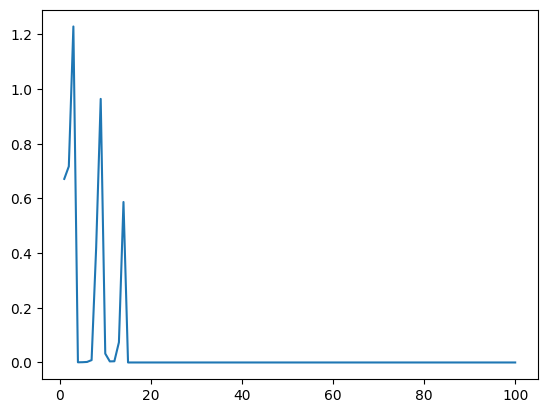

In [42]:
plt.plot([x for x in range(1, n_epochs + 1)], err)

In [43]:
X_test_hat = np.concatenate((np.ones((1, X_test.shape[1])), X_test), axis=0)
predictions = sigmoid(X_test_hat.T @ w[-1])
y_predicted = np.apply_along_axis(lambda x: 9 if x < 0.5 else 0, 1, predictions).reshape((-1,1))

/var/folders/m9/2qy1g_cd5mjcg_cqty8ydzq00000gn/T/ipykernel_8390/1431357966.py:2: RuntimeWarning: overflow encountered in exp
  return 1./(1.+np.exp(-x))


In [44]:
def compute_accuracy(y_true, y_guess):
    return (len(y_true) - np.count_nonzero(y_true - y_guess)) / len(y_true) * 100

In [45]:
compute_accuracy(y_predicted, y_test)

52.58413461538461

In [23]:
def GD_log_reg(f, grad_f, w0, D, tolf, tolx, kmax, alpha=0.1):
    # As output, we want:
    # x -> The stationary point
    # f_val -> A vector containing the values of f during the iterations
    # err_val -> A vector containing the values of ||grad_f(x_k)||

    f_val = [f(w0, D)]
    err_val = [grad_f(w0, D)]
    
    # Init iteration
    k = 0
    x = [w0]
    
    rel_tol_cond = True
    rel_inp_cond = True
    max_it_cond = True
    
    while rel_tol_cond and rel_inp_cond and max_it_cond:
        x.append(x[k] - alpha * grad_f(x[k], D))
        f_val.append(f(x[k+1], D))
        err_val.append(np.linalg.norm(grad_f(x[k], D)))
        
        k += 1
        if(k % 100 == 0): 
            print(f"iteration: {k}")
            print(err_val[-1])

        rel_tol_cond = np.linalg.norm(grad_f(x[k-1], D)) > tolf * np.linalg.norm(grad_f(w0, D))
        # We skip the first iteration
        rel_inp_cond = True if k == 0 else np.linalg.norm(x[k] - x[k-1]) > tolx
        max_it_cond = k < kmax

    return x[k], f_val, err_val

In [24]:
res_gd = GD_log_reg(l, grad_l2, w0, (X_hat, y_train), 0., 0., 500, alpha=0.4)
w_k, f_val, err_val = res_gd

/var/folders/m9/2qy1g_cd5mjcg_cqty8ydzq00000gn/T/ipykernel_8390/1431357966.py:2: RuntimeWarning: overflow encountered in exp
  return 1./(1.+np.exp(-x))


KeyboardInterrupt: 

In [ ]:
X_test_hat = np.concatenate((np.ones((1, X_test.shape[1])), X_test), axis=0)
predictions = sigmoid(X_test_hat.T @ w_k)
y_predicted = np.apply_along_axis(lambda x: 9 if x < 0.5 else 0, 1, predictions).reshape((-1,1))
compute_accuracy(y_test, y_predicted)

In [ ]:
print(f"class 0: {y_predicted[y_predicted == 0].shape[0]}\nclass 9: {y_predicted[y_predicted == 9].shape[0]}")